# Lab 3 - Network Intrusion Detection
- Daniel Vance
- Peter Thung
- Ravi Srinivas
- Randy Balzer

## Business Understanding

### Describe the purpose of the data set you selected 
- *Why was this data collected in the first place?* - The data set selected is the "UNSW_NB15" network traffic data set. The data set was created to evaluate Network Intrusion Detection Systems (NIDS). According to the creators of the data set, N. Moustafa and J. Slay from the Australian Defence Force Academy, the "quality of a NIDS data set reflects two important characteristics: comprehensive reflection of contemporary threats and an inclusive normal range of traffic [1]." Before this data set was generated, they argued that existing data sets used to train and test NIDS were not representative of current traffic flows and threats[2].
- Describe how you would define and measure the outcomes from the dataset. That is: 
    - *Why is this data important?* - The importance of this data set is that it will allow NIDS to be evaluated better, which will increase their performance, increase their protective power and reduce the chance of false positives and false negatives.
    - *How do you know if you have mined useful knowledge from the dataset?* - We will know we mined useful knowledge from the data set if we can determine, based on a collection of packets of traffic data, whether the features of those packets indicate an attack or just normal traffic.
    - *How would you measure the effectiveness of a good prediction algorithm? Be specific.*
    
With our particular dataset there are a couple of different view points on which performance metrics a model should be tuned for for this particular dataset:

1) False negatives are probably worse than false positives. If a malicious packet gets through undetected, it could potentially do bad things without being noticed, whereas a false positive could be rescreened or reviewed to clear the packet. Note: however, if the system has protection in depth, perhaps down stream systems may catch the packet or some effect of the malicous abnormal packet (e.g. host based intrusion detection system, so it may not be that bad). Recall may be a good metric to gauge model performance based on highlighting false negatives. Recall is defined as the number of True Postivies divided by the number of True Positives and the number of False Negatives, also known as Sensitivity or the True Postive Rate. 

2) However, if there are too may false positives, where the system over classifies packets as malcious when they really aren't then it could be interfering with normal operations and impact business operations. On the assumption that it takes some signficant amount of time to clear a tagged (false) positive packet. If a tool identifies too many false positives, people would lose trust with the system. Based on this view, precision which is defined as the number of True Positives divided by the number of True Positives and False positives would be a good metric to use to gauge performance of models used for predicting abnormal packets.

3) Based on these view points, a metric which combines both would be the F1 Score which is 2*((precision*recall)/(precision+recall)) also know as the F Score or F Measure which tries to convey the balance between precision and recall. 

*Source*
1. Moustafa, Nour, and Jill Slay. "UNSW-NB15: a comprehensive data set for network intrusion detection systems (UNSW-NB15 network data set)."Military Communications and Information Systems Conference (MilCIS), 2015. IEEE, 2015.
2. Moustafa, Nour, and Jill Slay. "The evaluation of Network Anomaly Detection Systems: Statistical analysis of the UNSW-NB15 data set and the comparison with the KDD99 data set." Information Security Journal: A Global Perspective (2016): 1-14.
3. https://www.unsw.adfa.edu.au/australian-centre-for-cyber-security/cybersecurity/ADFA-NB15-Datasets/

## Data Understanding

In [1]:
# Imports
# Python Version 2.7.12
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt
from sklearn.svm import SVC

from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.cluster import Birch, MiniBatchKMeans

%matplotlib inline

E:\anaconda\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\anaconda\envs\py27\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
E:\anaconda\envs\py27\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning

## UNSW_NB15_training_set
- A Network Intrusion Data Set.
    - 82332 rows x 45 columns
        - **id** *int* The id of the record
        - **dur** *float* Record's total duration
        - **proto** *Nominal* Tranaction Protocol
        - **service** *Nominal* http, ftp, ssh, dns, ..., else(-)
        - **state** *Nominal* The state and its dependent protocol e.g. ACC, CLO, FIN, INT, ..., else (-)
		- **spkts** *int* Source to destination packet count
		- **dpkts** *int* Destination to source packet count 
		- **sbytes** *int* Source to destination bytes
		- **dbytes** *int* Destination to source bytes
		- **rate** *float* We were unable to find a description of rate. It does contain outliers, but we were unable to find reason to throw it out. So we kept it at any *rate*
		- **sttl** *int* Source to destination bytes
		- **dttl** *int* Destination to source time to live
		- **sload** *float* Source bits per second
		- **dload** *float* Destination bits per second
		- **sloss** *int* Source packets retransmitted or dropped
		- **dloss** *int* Destination packets retransmitted or dropped
		- **sinpkt** *float* Source inter-packet arrival time(mSec)
		- **dinpkt** *float* Destination inetr-packet arrival time(mSec)
		- **sjit** *float* Source jitter (mSec)
		- **djit** *float* Destination jitter(mSec)
		- **swin** *int* Source TCP window advertisment
		- **stcpb** *int* Source TCP sequence number
		- **dtcpb** *int* Destination TCP sequence number
		- **dwin** *int* Destination TCP window advertisment
		- **tcprtt** *float* The sum of 'synack' and 'ackdat' of the TCP
		- **synack** *float* The time between the SYN and the SYN_ACK packets of the TCP
		- **ackdat** *float* The time between the SYN_ACK and the ACK packets of the TCP
		- **smean** *int* Mean of the flow packet size transmitted by the sre
		- **dmean** *int* Mean of the flow packet size transmitted by the dst
		- **trans_depth** *int* The depth into the connection of the http request/response transaction
		- **response_body_len** *int* The content size of the data transferred from the server's http service
		- **ct_srv_src** *int* No. of Connection that contain the same service (14) and source address in 100 connections according to the last time
		- **ct_state_ttl** *int* No. for each state (6) according to specific range if value for source/destination time to live
		- **ct_dst_ltm** *int* No of connection of the same destination address (3) in 100 connections according to the last time
		- **ct_src_dport_ltm** *int* No. of connection of the same source address and the destination port in 100 connections according to the last time
		- **ct_dst_sport_ltm** *int* No. of connnection of the same destination address(3) and the source port (2) in 100 connection according to the last time (26).
		- **ct_dst_src_ltm** *int* No connection of the same source (1) and the destination (3) address in 100 connection according to the last time (26)
		- **is_ftp_login** *byte* If the ftp session is accessed by user and password then 1 else 0
		- **ct_ftp_cmd** *int* No. of flows that has a command in ftp session
		- **ct_flw_http_mthd** *int* No. of flows that has methof such as Get and Post in http service
		- **ct_src_ltm** *int* No of connections of the same source address (1) in 100 connection according to the last time(26).
		- **ct_srv_dst** *int* No. of connectio that conbtain the same service and destination address in 100 connection according to the last time
		- **is_sm_ips_ports** *byte* If source equals to destination (3) IP addresses and port numbers (2)(4) are equal, this variable takes value 1 else 0
		- **attack_cat** *Nominal* The name of each attack category. In this data set, nine categories (e.g. Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms)
		- **label** *byte* 0 for normal and 1 for attack records

In [2]:
# Load UNSW_NB15 into a Pandas dataframe
# 'https://github.com/danielbots/network_intrusion_detection_system/blob/master/UNSW_NB15_training_set.csv'
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')
# Grab out the count of number of unique values in the attack_cat variable prior to removing it
# to use as a potential K value for Kmeans clustering algorithm

attack_cat = df.attack_cat.unique()
attack_cat_count = len(attack_cat)
print("Number of unique attack categories", attack_cat_count)
# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"      

df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] 

df_five.info()
df_five.describe()

('Number of unique attack categories', 10)
duplicate record deleted successfully: 82328 observations remaining
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 6 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
label               82328 non-null int64
dtypes: int64(6)
memory usage: 4.4 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,1.000000


In [3]:
# One-hot encode our object features:

# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)  # Note
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB


In [7]:
# df.describe() calculates the count, mean, standard deviation, min, max, and quartiles 
# of the data less the nominal (object) columns. 
pd.set_option('display.max_columns', 500)
df.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
count,82328.000000,82328.000000,82328.000000,8.232800e+04,8.232800e+04,8.232800e+04,82328.000000,82328.00000,8.232800e+04,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,8.232800e+04,82328.000000,82328.000000,8.232800e+04,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328

Summary statistics above are for numeric data types with a totoal of 41 features. The count of 82332 indicate no missing data.

Binary Data types are **is_sm_ips_ports, is_ftp_login, label**:
- **is_sm_ips_ports** Min = 0, Max = 1, which is what I would expect as it is binary in nature
- **is_ftp_login** Min = 0, Max = 2, We wouldn't expect max = 2 for this feature (Marked as anomalous, see section on data quality for explanation)
- **label** Min = 0, Max = 1, which is what we would expect as it is binary in nature where 0 means it is a normal packet, while 1 means it is an attack record (or abnormal)

In [26]:
# List the unique values of each nominal column
header = df.columns.values.tolist()
for column in header:
    if column in df.select_dtypes(include=["object"]):
        print column + ":\n", df[column].unique()

proto:
['udp' 'arp' 'tcp' 'igmp' 'ospf' 'sctp' 'gre' 'ggp' 'ip' 'ipnip' 'st2'
 'argus' 'chaos' 'egp' 'emcon' 'nvp' 'pup' 'xnet' 'mux' 'dcn' 'hmp' 'prm'
 'trunk-1' 'trunk-2' 'xns-idp' 'leaf-1' 'leaf-2' 'irtp' 'rdp' 'netblt'
 'mfe-nsp' 'merit-inp' '3pc' 'idpr' 'ddp' 'idpr-cmtp' 'tp++' 'ipv6' 'sdrp'
 'ipv6-frag' 'ipv6-route' 'idrp' 'mhrp' 'i-nlsp' 'rvd' 'mobile' 'narp'
 'skip' 'tlsp' 'ipv6-no' 'any' 'ipv6-opts' 'cftp' 'sat-expak' 'ippc'
 'kryptolan' 'sat-mon' 'cpnx' 'wsn' 'pvp' 'br-sat-mon' 'sun-nd' 'wb-mon'
 'vmtp' 'ttp' 'vines' 'nsfnet-igp' 'dgp' 'eigrp' 'tcf' 'sprite-rpc' 'larp'
 'mtp' 'ax.25' 'ipip' 'aes-sp3-d' 'micp' 'encap' 'pri-enc' 'gmtp' 'ifmp'
 'pnni' 'qnx' 'scps' 'cbt' 'bbn-rcc' 'igp' 'bna' 'swipe' 'visa' 'ipcv'
 'cphb' 'iso-tp4' 'wb-expak' 'sep' 'secure-vmtp' 'xtp' 'il' 'rsvp' 'unas'
 'fc' 'iso-ip' 'etherip' 'pim' 'aris' 'a/n' 'ipcomp' 'snp' 'compaq-peer'
 'ipx-n-ip' 'pgm' 'vrrp' 'l2tp' 'zero' 'ddx' 'iatp' 'stp' 'srp' 'uti' 'sm'
 'smp' 'isis' 'ptp' 'fire' 'crtp' 'crudp' 'sccop

In [54]:
# Summary statistics on the categrical features in our dataset.
df.describe(include=['O'])

,proto,service,state,attack_cat
count,82328,82328,82328,82328
unique,131,13,7,10
top,tcp,-,FIN,Normal
freq,43091,47153,39335,37000


### Verify data quality: Explain any missing values, duplicate data, and outliers.
    - Are those mistakes? How do you deal with these problems? Be specific.

In [43]:
""" There are four records that we found that do not fit with the given feature definitions. 
    The feature "is_ftp_login" is a "byte" field. Investigating the data, we found that these 
    four records are identical to each other. The feature definition states that if the ftp 
    session is accessed by user and password then the record will have a one, otherwise a zero. 
    We are unable to determine whether these records used and ftp username and password, and 
    since they are only four out of 82k records (4 / 82332 = 4.85 * 10^(-5)) we thought that 
    eliminating them from the data set was the best choice with minimal impact.
"""
df[df.is_ftp_login == 2]

,﻿id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
9434,9435,0.448151,tcp,ftp,FIN,10,10,602,690,42.396425,62,252,9675.310547,11085.54981,1,3,49.794555,30.815,70.163992,1692.426333,255,158848246,992060022,255,0.0,0.0,0.0,60,69,0,0,2,1,4,2,2,4,2,2,0,4,2,0,Exploits,1
11136,11137,0.448151,tcp,ftp,FIN,10,10,602,690,42.396425,62,252,9675.310547,11085.54981,1,3,49.794555,30.815,70.163992,1692.426333,255,158848246,992060022,255,0.0,0.0,0.0,60,69,0,0,2,1,4,2,2,4,2,2,0,4,2,0,Exploits,1
11139,11140,0.448151,tcp,ftp,FIN,10,10,602,690,42.396425,62,252,9675.310547,11085.54981,1,3,49.794555,30.815,70.163992,1692.426333,255,158848246,992060022,255,0.0,0.0,0.0,60,69,0,0,2,1,4,2,2,4,2,2,0,4,2,0,Exploits,1
11811,11812,0.448151,tcp,ftp,FIN,10,10,602,690,42.396425,62,252,9675.310547,11085.54981,1,3,49.794555,30.815,70.163992,1692.426333,255,158848246,992060022,255,0.0,0.0,0.0,60,69,0,0,2,1,4,2,2,4,2,2,0,4,2,0,Exploits,1


In [8]:
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records
df = df[df.is_ftp_login != 2]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB


### Outliers

In [58]:
# using += 1.5 IQR to determine outliers from continous/oridnal numbers. 
df_desc_table = df.describe() # result: 41 numeric types
col_rate = df_desc_table['rate']
df_sub2 =df[['rate']]

q1 = df_desc_table.iloc[4]['rate']  # 4 = 25% row of description table or Q1
q3 = df_desc_table.iloc[6]['rate']  # 6 = 75% row of description table or Q3
iqr = q3 - q1
upper_outlier_threshold = q3 + (1.5 * iqr) 
lower_outlier_threshold = q1 - (1.5 * iqr)

col_index = df.columns
col_index.get_values() # Returns an array of column names 
col = df['rate']
lower_outliers = col[col < lower_outlier_threshold]
upper_outliers = col[col > upper_outlier_threshold]

print "Number of observations", len(col)
print "Number of lower outliers", len(lower_outliers)
print "Number of upper outliers", len(upper_outliers)

Number of observations 82328
Number of lower outliers 0
Number of upper outliers 6201


In [61]:
# Code that calculates the number of outliers below and above for continous numeric features.
# this is to help determine which particular feature to do box plots on.
#ref: http://stackoverflow.com/questions/24901766/python-how-to-get-column-names-from-pandas-dataframe-but-only-for-continuous
df_cont = df.select_dtypes(['float64', 'int64']) # a data frame of just continous variables
### len(df_cont.columns)
#df_cont.drop('id', axis=1, inplace=True) # 1 is the axis number ( 0 for rows 1 for columns), dropping id as it doesn't make sense to plot outliers for that column
### len(df_cont.columns)
print "Column name: #obserations: #lower_outliers: #upper_outliers: Max Values"
num_features_with_outliers = 0
for col_name in df_cont.columns:
    q1 = df_desc_table.iloc[4][col_name]  # 4 = 25% row of description table or Q1
    q3 = df_desc_table.iloc[6][col_name]  # 6 = 75% row of description table or Q3
    max_val = df_desc_table.iloc[7][col_name] # 7 = max value
    iqr = q3 - q1
    upper_outlier_threshold = q3 + (1.5 * iqr) 
    lower_outlier_threshold = q1 - (1.5 * iqr)
    col = df[col_name]
    lower_outliers = col[col < lower_outlier_threshold]
    upper_outliers = col[col > upper_outlier_threshold]
    if (len(lower_outliers) + len(upper_outliers)) > 0:
        num_features_with_outliers+=1
        print col_name + ": " + str(len(col)) + " : " + str(len(lower_outliers)) + " : " + str(len(upper_outliers)) + " : " + str(max_val)
print "Number of features with outliers: " + str(num_features_with_outliers)

Column name: #obserations: #lower_outliers: #upper_outliers: Max Values
dur: 82328 : 0 : 5868 : 59.999989
spkts: 82328 : 0 : 10196 : 10646.0
dpkts: 82328 : 0 : 8907 : 11018.0
sbytes: 82328 : 0 : 9270 : 14355774.0
dbytes: 82328 : 0 : 12308 : 14657531.0
rate: 82328 : 0 : 6201 : 1000000.003
sload: 82328 : 0 : 6715 : 5268000256.0
dload: 82328 : 0 : 18112 : 20821108.0
sloss: 82328 : 0 : 5499 : 5319.0
dloss: 82328 : 0 : 11272 : 5507.0
sinpkt: 82328 : 0 : 5667 : 60009.992
dinpkt: 82328 : 0 : 4717 : 57739.24
sjit: 82328 : 0 : 6320 : 1483830.917
djit: 82328 : 0 : 8569 : 463199.2401
tcprtt: 82328 : 0 : 2019 : 3.821465
synack: 82328 : 0 : 2954 : 3.226788
ackdat: 82328 : 0 : 2480 : 2.928778
smean: 82328 : 0 : 11928 : 1504.0
dmean: 82328 : 0 : 9902 : 1500.0
trans_depth: 82328 : 0 : 7582 : 131.0
response_body_len: 82328 : 0 : 5657 : 5242880.0
ct_srv_src: 82328 : 0 : 10093 : 63.0
ct_state_ttl: 82328 : 0 : 1833 : 6.0
ct_dst_ltm: 82328 : 0 : 10479 : 59.0
ct_src_dport_ltm: 82328 : 0 : 11476 : 59.0
ct_ds

Based on the code above there are 33 features with outliers based on 1.5 IQR standard. Note: Results were pulled out into excel to sort on number of outliers and max value to try and triage which variables to look at. Interesting to note: there were no lower outliers, just upper outliers. The top 5 features based on large number of outliers are [feature name (number of outliers)]: dload (18112) ct_dst_src_ltm (12789) dbytes(12308) smean(11928) ct_src_dport_ltm(11476)

Sorting by max_value will help to do box plots for variables with similar magnitude: E.g. 'dpkts', 'spkts' are similir in max value 'dloss', 'sloss' are similar in max value 'ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm' are similar in max vax value

Looking at the histogram and boxplot for dpkts and spkts (below), there seems to be a lot of values very close to 0 and they seem to track each other in quantity. I wouldn't be surprised if they were highly correlated. They have very similar steep central distribution centered around 0. With the network setup I wouldn't expect packets to have more than 6 hops based on the network setup. Based on the summary statistics, 75% the dpkts and spkts have greater than 12, 10 respectively with max values of 10646.000000 11018.000000, respectively. It would be interesting to see if there may be any correlation with these values greater than 75% of the norm correlate to abnormal traffic. *See Explore relationships for further analysis with these particular features*. (Pearson Correlation heat map shows value of .37 , which indicates some postive correlation of small to medium strength). From an outlier perspective, however, it is not clear whether these packets are expected anomolies, or errors in recording. Will leave them in the dataset for now.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C283C18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C4FDF98>]], dtype=object)

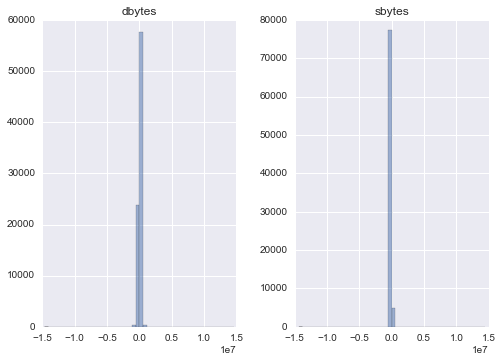

In [55]:
df[['dbytes', 'sbytes']].diff().hist(alpha=0.5, bins=50)

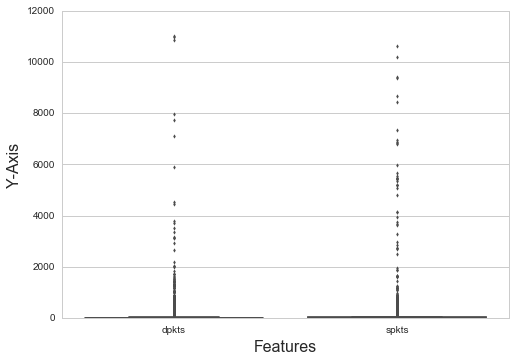

In [98]:
#Set up the graph parameters
sns.set(context='notebook', style='whitegrid')
sns.axlabel(xlabel="Features", ylabel="Y-Axis", fontsize=16)
sns.boxplot(data=df[['dpkts', 'spkts']] , fliersize=3)

In [73]:
""" Compare the percentage of source to destination packets for Attack and for
    Normal traffic. We can see that Normal traffic accounts for 65% of
    the source to destination packets that are sent, while Attack only produce
    source to destination packets roughly 35% of the time. 
"""
denom = df[(df['spkts'] > 10)]
numerator = df[(df['spkts'] > 10) & (df['label'] == 1)]
print "Percent of packets that have spkts > 12 and are labelled as an 'Attack' = " + str((float(len(numerator))/len(denom)) * 100)
numerator  = df[(df['spkts'] > 10) & (df['label'] == 0)]
print "Percent of packets that have spkts > 12 and 'Normal' = " + str((float(len(numerator))/len(denom)) * 100)

Percent of packets that have spkts > 12 and are labelled as an 'Attack' = 34.5773825564
Percent of packets that have spkts > 12 and 'Normal' = 65.4226174436


In [72]:
""" Compare the percentage of destination to source packets for Attack and for
    Normal traffic. We can see that Normal traffic accounts for nearly 70% of
    the destination to source packets that are sent, while Attack only produce
    destination to source packets 30% of the time. 
"""
denom = df[(df['dpkts'] > 10)]
numerator = df[(df['dpkts'] > 10) & (df['label'] == 1)]
print "Percent of packets that have dpkts > 10 and are labelled as an 'Attack' = " + str((float(len(numerator))/len(denom)) * 100)
numerator  = df[(df['dpkts'] > 10) & (df['label'] == 0)]
print "Percent of packets that have dpkts > 10 and 'Normal' = " + str((float(len(numerator))/len(denom)) * 100)

Percent of packets that have dpkts > 10 and are labelled as an 'Attack' = 30.4111342185
Percent of packets that have dpkts > 10 and 'Normal' = 69.5888657815


Features dloss and sloss are the source or destination packets retransmitted or dropped. 
dloss and sloss also see to have a lot of values near zero and also seem to have roughly the same amount. We would not be surprised to see these variables correlate to each other. They have very similar steep central distribution centered around zero

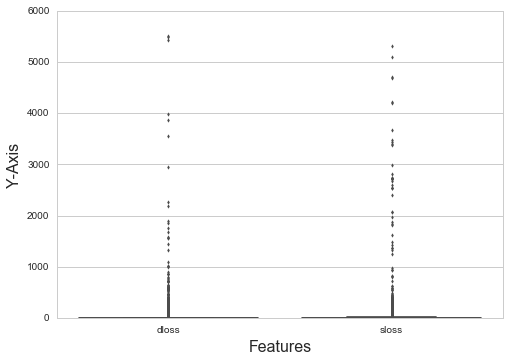

In [64]:
sns.axlabel(xlabel="Features", ylabel="Y-Axis", fontsize=16)
sns.boxplot(data=df[['dloss', 'sloss']] , fliersize=3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BA11240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000BA60F28>]], dtype=object)

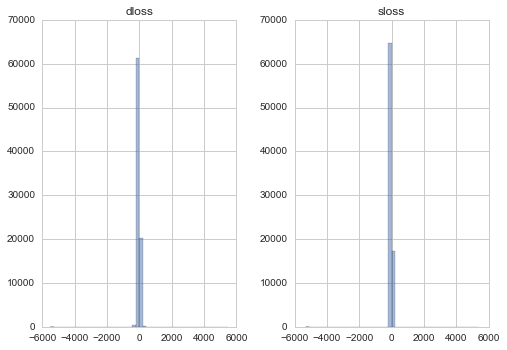

In [65]:
df[['dloss', 'sloss']].diff().hist(alpha=0.5, bins=50)

Features 'ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm' 
The features also seem to have a lot of values near 0 although slighly wider spread then previous features. Again, would not be surprised to see these variables correlate to each other. They have very similar steep central distribution centered around 0.

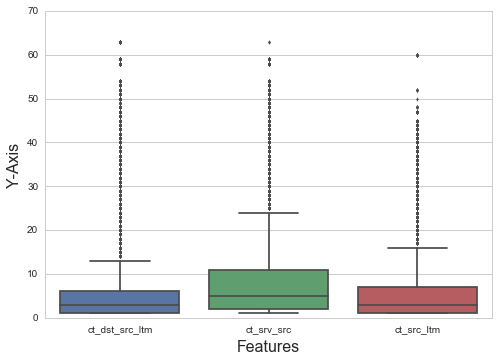

In [67]:
sns.axlabel(xlabel="Features", ylabel="Y-Axis", fontsize=16)
sns.boxplot(data=df[['ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm']] , fliersize=3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012F05630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001355B2E8>]], dtype=object)

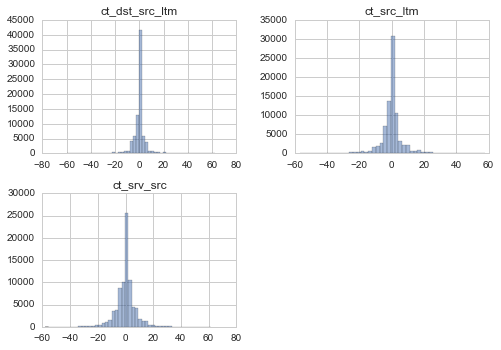

In [68]:
df[['ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm']].diff().hist(alpha=0.5, bins=50)

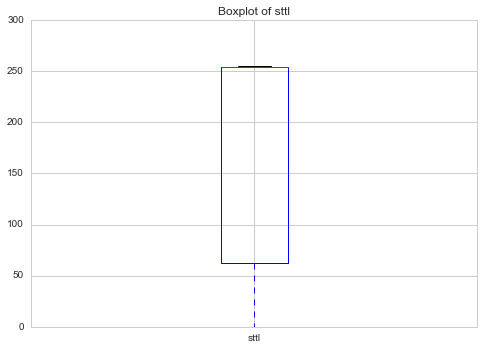

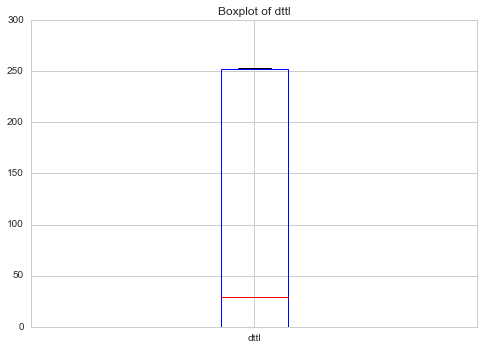

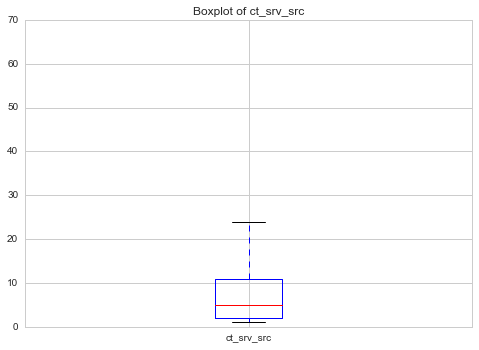

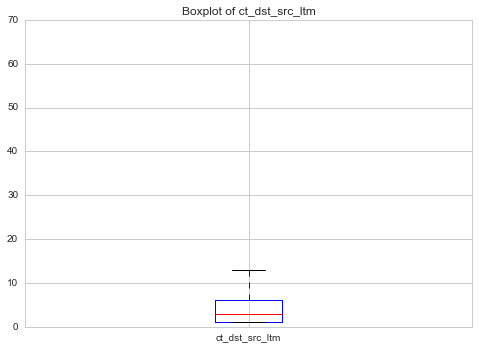

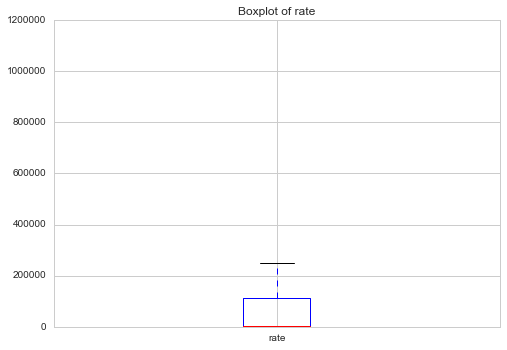

"\nplt.boxplot(x=[df.dttl],labels=['dttl'])\nplt.show()\n\nplt.boxplot(x=[df.ct_srv_src],labels=['ct_srv_src'])\nplt.show()\n\nplt.boxplot(x=[df.ct_dst_src_ltm],labels=['ct_dst_src_ltm'])\nplt.show()\n\nplt.boxplot(x=[df.rate],labels=['rate'])\nplt.show()\n"

In [71]:
""" Investigating the data, we find a lot of it is confined to ranges by the nature of the data (data 
    ranging from 0 to 255, etc.) As mentioned above, we did find continuous variables that did include 
    outliers, which we did decide to keep in the data set because we did not have a reason to throw 
    them out.
"""
# Five selected columns besides those above to get a "feel" for the data
columns = ["sttl", "dttl", "ct_srv_src", "ct_dst_src_ltm", "rate"]
for column in columns:
    plt.boxplot(x=[df[column]], labels=[column])
    plt.title("Boxplot of " + column)
    plt.show()

###  Give simple, appropriate statistics (range, mode, mean, median, variance, counts, etc.) for the most important attributes and describe what they mean or if you found something interesting. 
    - Note: You can also use data from other sources for comparison. Explain the significance of the statistics run and why they are meaningful. 

The data can have two response variables. Those features are *label* and *attack_cat*. When *label* is equal to one, then there *attack_cat* is one of nine possible attacks. When *label* is equal to zero, *attack_cat* is equal to 'Normal'. The *attack_cat* was removed from the data set for simplicities sake in this current interation.

In [80]:
df["label"].value_counts()

1    45328
0    37000
Name: label, dtype: int64

In [88]:
df.groupby(["label"]).describe()

ackdat    ct_dst_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
label                                                                       
0     count  37000.000000  37000.000000      37000.000000    37000.000000   
      mean       0.034019      3.340973          1.085432        3.918649   
      std        0.072239      3.604964          0.331380        5.710431   
      min        0.000000      1.000000          1.000000        1.000000   
      25%        0.000000      1.000000          1.000000        1.000000   
      50%        0.000146      2.000000          1.000000        2.000000   
      75%        0.061317      4.000000          1.000000        4.000000   
      max        2.928778     48.000000          4.000000       48.000000   
1     count  45328.000000  45328.000000      45328.000000    45328.000000   
      mean       0.020672      7.707355          5.767164       10.344401   
      std        0.034256     10.466142          7.322400       13.838721   
      min        0.000000      1.000000          1.000000        1.000000   
      25%        0.000000      1.000000          1.000000        1.000000   
      50%        0.000000      3.000000          2.000000        4.000000   
      75%        0.044840      8.000000          6.000000       12.000000   
      max        0.435431     59.000000         38.000000       63.000000   

             ct_flw_http_mthd    ct_ftp_cmd  ct_src_dport_ltm    ct_src_ltm  \
label                                                                         
0     count      37000.000000  37000.000000      37000.000000  37000.000000   
      mean           0.182784      0.010135          1.757541      3.853541   
      std            0.827688      0.101769          1.804013      4.019296   
      min            0.000000      0.000000          1.000000      1.000000   
      25%            0.000000      0.000000          1.000000      1.000000   
      50%            0.000000      0.000000          1.000000      2.000000   
      75%            0.000000      0.000000          2.000000      5.000000   
      max           16.000000      2.000000         18.000000     41.000000   
1     count      45328.000000  45328.000000      45328.000000  45328.000000   
      mean           0.086459      0.006773          7.517848      8.602983   
      std            0.421376      0.082019         10.501187     10.453143   
      min            0.000000      0.000000          1.000000      1.000000   
      25%            0.000000      0.000000          1.000000      2.000000   
      50%            0.000000      0.000000          2.000000      4.000000   
      75%            0.000000      0.000000          7.000000     11.000000   
      max           16.000000      1.000000         59.000000     60.000000   

               ct_srv_dst    ct_srv_src  ct_state_ttl        dbytes  \
label                                                                 
0     count  37000.000000  37000.000000  37000.000000  3.700000e+04   
      mean       5.558270      5.984297      0.993027  1.870493e+04   
      std        5.737014      5.951828      1.383006  1.090385e+05   
      min        1.000000      1.000000      0.000000  0.000000e+00   
      25%        2.000000      2.000000      0.000000  1.640000e+02   
      50%        4.000000      4.000000      1.000000  3.540000e+02   
      75%        7.000000      7.000000      1.000000  1.890000e+03   
      max       48.000000     49.000000      6.000000  1.925422e+06   
1     count  45328.000000  45328.000000  45328.000000  4.532800e+04   
      mean      12.108366     12.455083      1.676425  8.768948e+03   
      std       13.360665     13.253893      0.545402  1.786756e+05   
      min        1.000000      1.000000      0.000000  0.000000e+00   
      25%        1.000000      2.000000      1.000000  0.000000e+00   
      50%        7.000000      7.000000      2.000000  0.000000e+00   
      75%       17.000000     18.000000      2.000000  3.540000e+02   
  

Above you can see the different values and their counts for the *label* and *attack_cat* features in our data set, as well as the summary statistics broken down by whether they were an 'Attack' or not.

The other attributes that we found to be significant, using the heatmaps below as compared to *label*, are:

**positive** correlation:
- sttl : 0.5
- ct_dst_sport_ltm : 0.39
- ct_src_dport_ltm : 0.34

**negative** correlation:
- swin : 0.41
- dwin : 0.37

For *sttl*, the source to destination bytes *hop limit*[4], we see that a large portion of the 'Attacks' use a *time to live* of 254 bytes. When there is not an attack, the majority of the values are 31, followed closely by 254. 

In [103]:
df.groupby(["label"]).sttl.value_counts()

label  sttl
0      31      16702
       254     15049
       62       4129
       0         987
       29         50
       1          38
       60         24
       32         19
       30          2
1      254     39000
       62       6241
       0          61
       255        25
       63          1
Name: sttl, dtype: int64

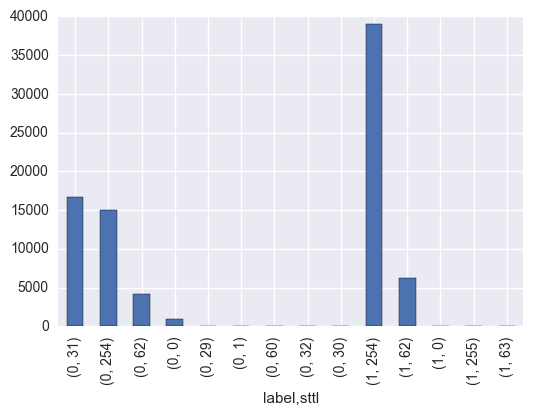

In [8]:
df.groupby(["label"]).sttl.value_counts().plot.bar()

**ct_dst_sport_ltm** and **ct_src_dport_ltm** No. of connnection of the same destination/source address(3) and the source/destination port (2) in 100 connection according to the last time (26).
- This feature is unusual in that it uses features that this data set does not have. Features in the original data set have the source and destination IP and the start timestamp and last timestamp. 
- This feature is correlated with the *label* feature, so it is of interest in that respect too.

In [9]:
df.groupby(["label"]).ct_dst_sport_ltm.value_counts()

label  ct_dst_sport_ltm
0      1                   34334
       2                    2262
       3                     313
       4                      91
1      1                   19549
       4                    5036
       2                    4258
       3                    4186
       25                   2251
       18                   2127
       6                    1063
       14                    618
       16                    565
       10                    453
       13                    440
       8                     437
       15                    436
       17                    402
       11                    400
       9                     374
       12                    330
       20                    330
       5                     329
       22                    311
       19                    307
       23                    288
       24                    287
       21                    255
       7                     238
       27          

In [10]:
df.groupby(["label"]).ct_src_dport_ltm.value_counts()

label  ct_src_dport_ltm
0      1                   25879
       2                    6164
       3                    1690
       6                    1117
       5                     648
       4                     524
       7                     272
       9                     140
       8                     119
       10                     88
       13                     79
       12                     73
       11                     71
       14                     69
       15                     28
       16                     27
       18                     12
1      1                   17302
       2                    5493
       4                    4121
       3                    3483
       7                    2017
       25                   1661
       18                   1598
       6                    1178
       43                    909
       14                    541
       5                     506
       16                    442
       10          

It does appear that when an Attack is occuring there can be many more connections made than when it is just Normal traffic. In the *ct_dst_sport_ltm* feature, 'Normal' traffic does not get more than four connections, but when there is an 'Attack' up to 38 connections can be made to a given destination port. 

When Attack is True, the swin value is either 0 or 255, where as 'Normal' traffic has a range between 0 and 255 inclusive. There are:
- 30k attack records when swin/dwin is 0
- 15k attack records when swin/dwin is 255

In [102]:
df.groupby(["label"]).swin.value_counts()

label  swin
0      255     27839
       0        9152
       5           1
       43          1
       52          1
       67          1
       99          1
       154         1
       156         1
       202         1
       245         1
1      0       30085
       255     15243
Name: swin, dtype: int64

We can see that a third of the time there is an 'Attack' the *swin* value is 255, while two-thirds of the time it is zero. This is in stark contrast with what we see when there is not an 'Attack.' When the *label* is zero (meaning 'Normal' network traffic), the majority (approximately 75%) of the values are 255, while only a quarter of the traffic is zero. This could indicate that a *swin* value of zero is indicitive of an attack. 

### Visualize the most important attributes appropriately (at least 5 attributes).
    - Important: Provide an interpretation for each chart. Explain for each attribute why the chosen visualization is appropriate. 

As noted above, using the Heat maps found below, we were able to get the top features that were correlated with the *label* feature. Here we continue to visualize those features, beginning with boxplots of the data contrasting them by whether the data was associated with an "Attack" or not. 

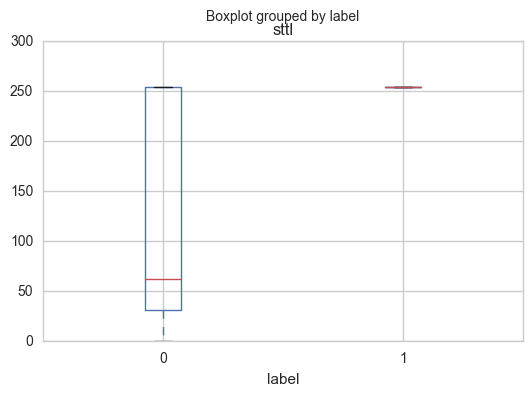

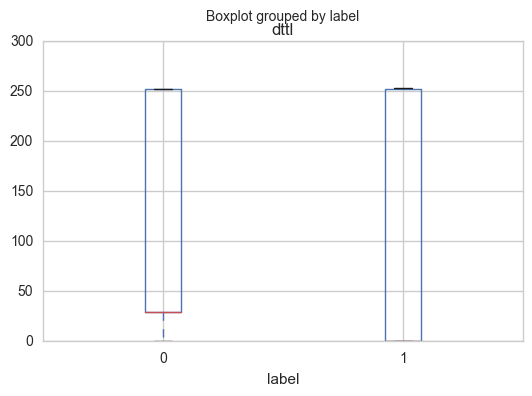

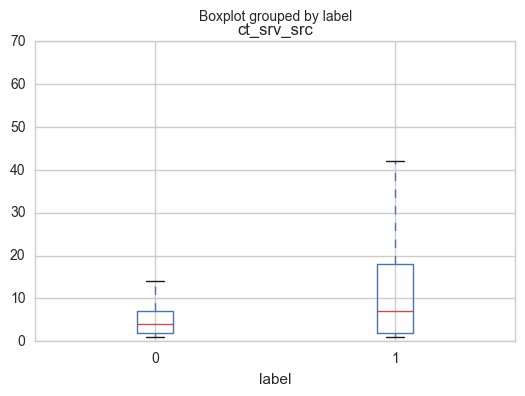

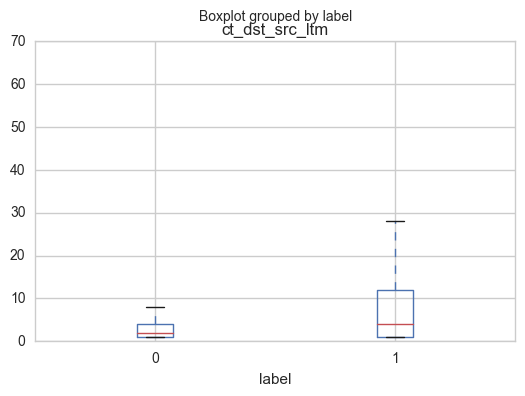

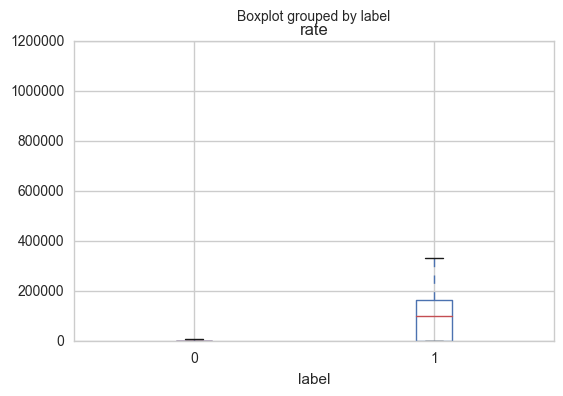

In [23]:
#sttl
df.boxplot(column="sttl", by="label")
#dttl
df.boxplot(column="dttl", by="label")
plt.show()
#ct_srv_src
df.boxplot(column="ct_srv_src", by="label")
plt.show()
#ct_dst_src_ltm
df.boxplot(column="ct_dst_src_ltm", by="label")
#rate
df.boxplot(column="rate", by="label")
plt.show()

In [11]:
# Create the data frame again, but leave the attack_cat feature in for graphing.
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')
# Grab out the count of number of unique values in the attack_cat variable prior to removing it
# to use as a potential K value for Kmeans clustering algorithm

        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 

duplicate record deleted successfully: 82328 observations remaining


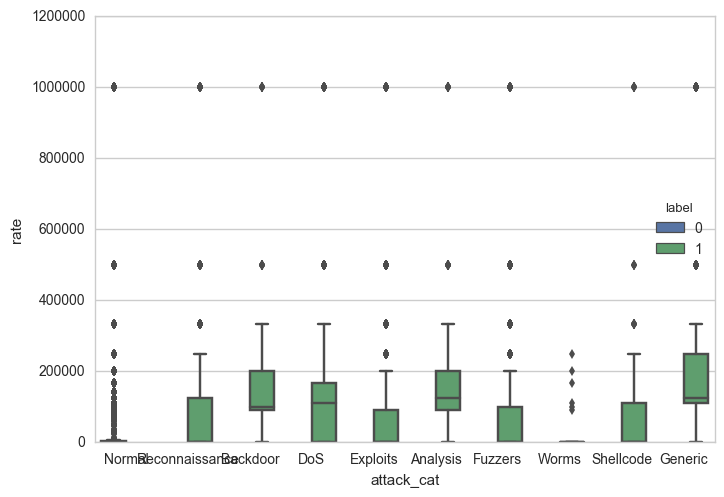

In [11]:
""" A breakdown of the attacks used in this data set by the rate at which
    we think they occurred. 
"""
sns.set(style="whitegrid", color_codes=True)
ax = sns.boxplot(x="attack_cat",y="rate", hue= "label",data=df)

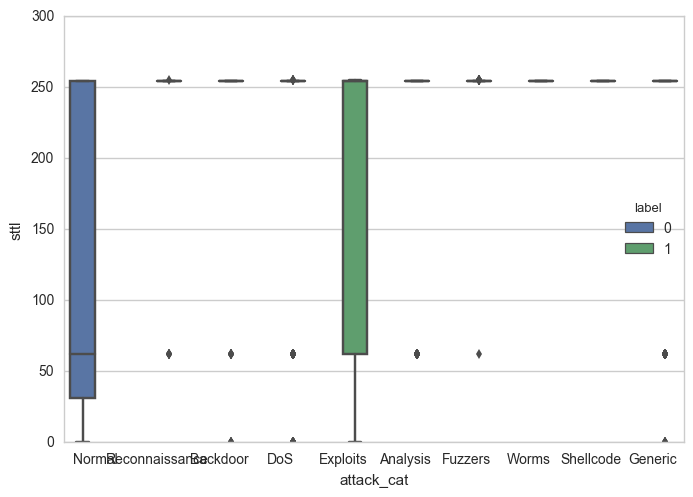

In [12]:
""" Using the feature *sttl* we see that most of the values are 255
    except when the value is Normal or an Exploit attack. We also 
    see that 0 (Normal traffic) has a median closer to 56, meaning 
    that a sttl near 255 could indicate that an attack is occuring
"""
sns.set(style="whitegrid", color_codes=True)
ax = sns.boxplot(x="attack_cat",y="sttl", hue= "label",data=df)

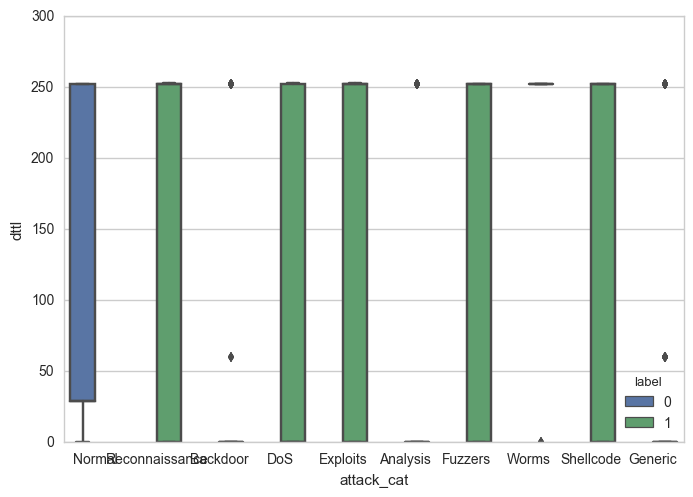

In [13]:
""" If we look at the "dttl" feature, we see a slightly different picture.
    It isn't surprising to see DoS attacks with values of 255, but five out
    of the nine attacks have values between zero and 255. The unusual attacks
    are Backdoor, Analysis, and Generic, which are a majority of zeroes, with
    outliers in the 255 range.
"""
sns.set(style="whitegrid", color_codes=True)
ax = sns.boxplot(x="attack_cat",y="dttl", hue= "label",data=df)

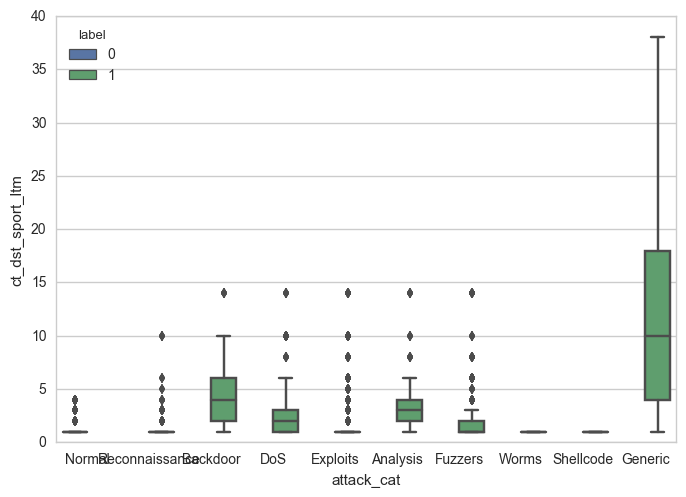

In [16]:
""" We can see from this graph, that the graph reflects what we numerically saw in the 
    previous section. The Normal traffic is much closer to zero connections, where
    the Attack traffic is much more varied in the number of connections that it makes.
"""
sns.set(style="whitegrid", color_codes=True)
ax = sns.boxplot(x="attack_cat",y="ct_dst_sport_ltm", hue= "label",data=df)

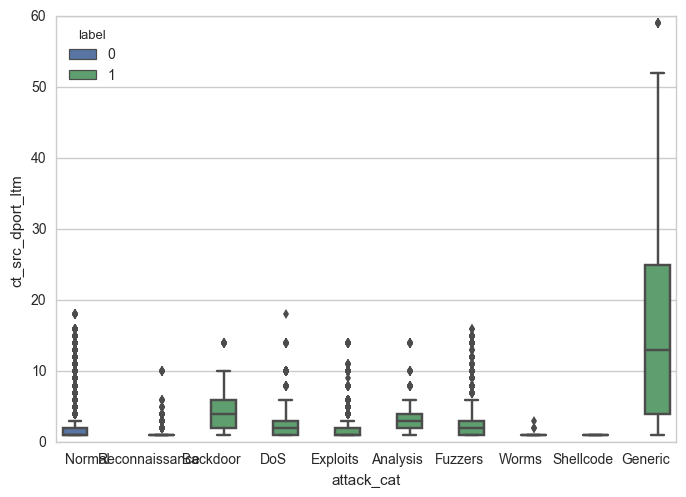

In [17]:
""" As we perceived earlier, there seems less of a corroboration between this feature
    as far as the "attack_cat" goes, except in the "Generic" attack category. 
"""
sns.set(style="whitegrid", color_codes=True)
ax = sns.boxplot(x="attack_cat",y="ct_src_dport_ltm", hue= "label",data=df)

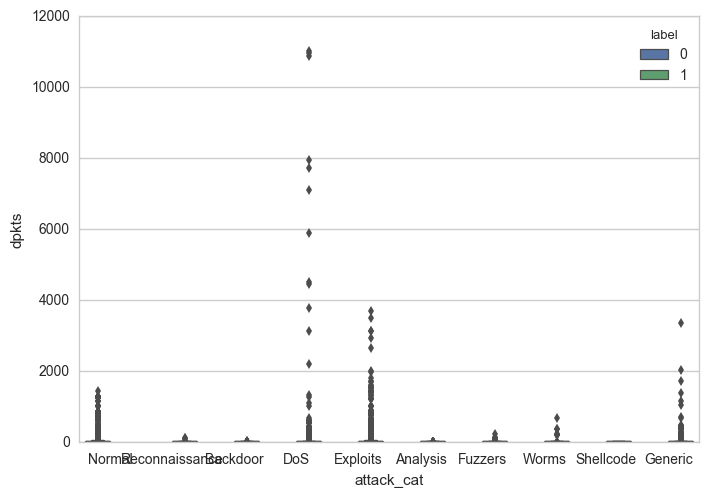

In [18]:
""" Looking at the dpkts feature from the outlier section, we see that most of the
    outliers come from the DoS attack, which makes sense that the DoS attack would
    get overwhelmed by trying to return requests, thus cause the DoS.
"""
sns.set(style="whitegrid", color_codes=True)
ax = sns.boxplot(x="attack_cat",y="dpkts", hue= "label",data=df)

### Explore relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. 
    - Explain any interesting relationships.

In [13]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')
# Grab out the count of number of unique values in the attack_cat variable prior to removing it
# to use as a potential K value for Kmeans clustering algorithm

attack_cat = df.attack_cat.unique()
attack_cat_count = len(attack_cat)
print("Number of unique attack categories", attack_cat_count)
# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"      

('Number of unique attack categories', 10)
duplicate record deleted successfully: 82328 observations remaining


**Feature: dpkts**
It is interesting to note that for the expected_dpkts_size (which is defined as anything less than the 75% quartile (< 10) there are more attack packets than normal ones. Conversely, for unexpected dpkts size (>=10) the reverse is true.

label_cat              attack  normal
dpkts_cat                            
expected_dpkts_size     39625   23950
unexpected_dpkts_size    5703   13050


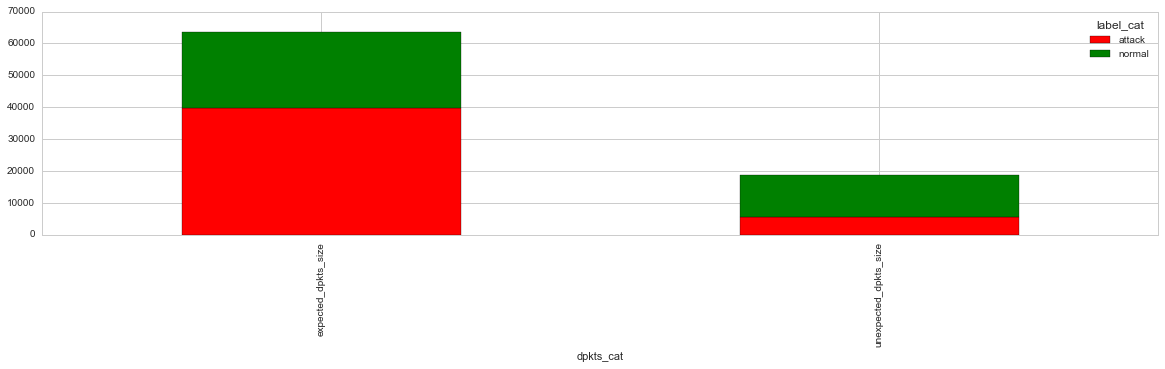

In [75]:
# Defensive copy of original dataframe.
df2 = df.copy(deep=True)
bins =[-1, 10, 11019] # Note: values needed to be slighlty greater than the min and max values to ensure the get counted.
bins2 = [-1, .5, 2]  # created bins 2 to rename 0, 1 ( false, true) to normal, abnormal to intepret plot easier.
group_names = ['expected_dpkts_size', 'unexpected_dpkts_size']
group_names2 = ['normal', 'attack']
categories = pd.cut(df2['dpkts'], bins, labels=group_names)
categories2 = pd.cut(df2['label'], bins2, labels=group_names2)
df2['dpkts_cat'] =  pd.cut(df2['dpkts'], bins, labels=group_names)
df2['label_cat'] =  pd.cut(df2['label'], bins2, labels=group_names2)
#abnormal_counts = pd.crosstab([df2['dpkts_cat']], df2.label.astype(bool))
abnormal_counts = pd.crosstab([df2['dpkts_cat']], df2.label_cat.astype(str))
print abnormal_counts
#abnormal_counts.plot(kind='bar', stacked=True, color=['green','red'], figsize=(20,4))
abnormal_counts.plot(kind='bar', stacked=True, color=['red','green'], figsize=(20,4)) # swap color when switch out label to abnormal/normal

**Heat Maps** for every feature compared to *label*
- As noted above, we chose the 5 features with the most correlation, positive or negative.

In [37]:
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

#attack records
df1_1 = df[['label', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss']]
df1_1 = df1_1[df1_1.label == 1]

df1_2 = df[['label', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb']]
df1_2 = df1_2[df1_2.label == 1]

df1_3 = df[['label', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'tcprtt']]
df1_3 = df1_3[df1_3.label == 1]

## normal records
df0_1 = df[['label', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss']]
df0_1 = df0_1[df0_1.label == 0]

df0_2 = df[['label', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb']]
df0_2 = df0_2[df0_2.label == 0]

df0_3 = df[['label', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'tcprtt']]
df0_3 = df0_3[df0_3.label == 0]


## both attack and normal records
df_1 = df[['label', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss']]
df_2 = df[['label', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'ct_src_dport_ltm', 'ct_dst_sport_ltm']]
df_3 = df[['label', 'stcpb', 'dtcpb', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'tcprtt']]
df_4 = df[['label', 'sinpkt', 'dinpkt', 'synack', 'ackdat', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm','ct_src_dport_ltm', 'ct_dst_sport_ltm']]
df_5 = df[['label', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']]

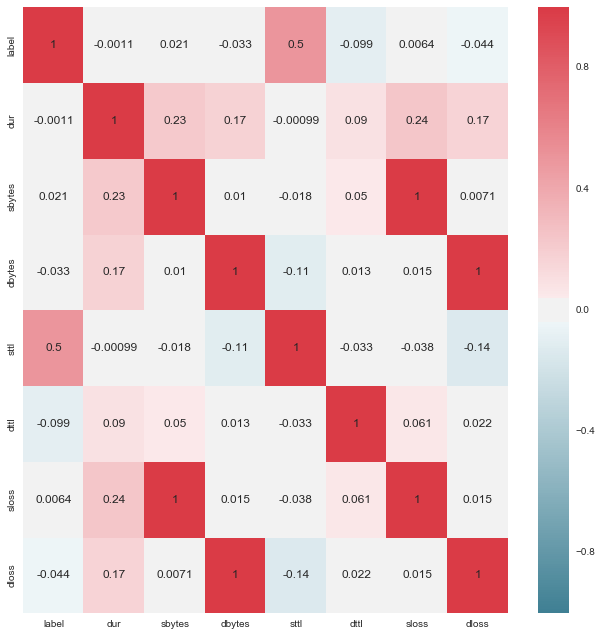

In [49]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_1.corr(), cmap=cmap, annot=True)

f.tight_layout()

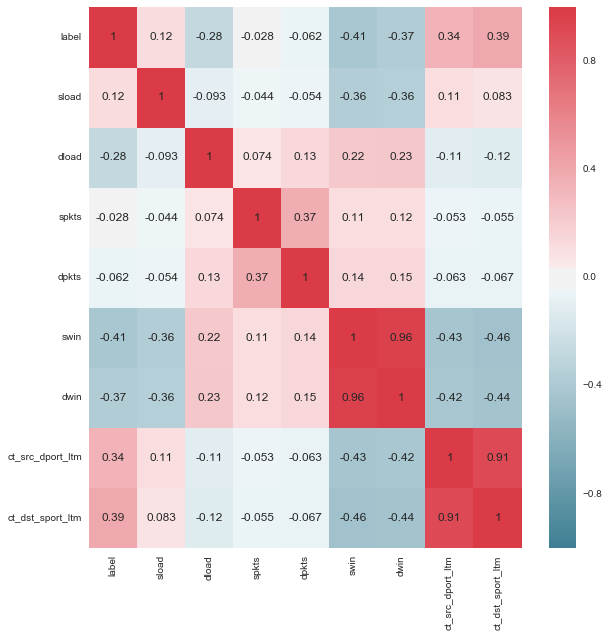

In [50]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_2.corr(), cmap=cmap, annot=True)

f.tight_layout()

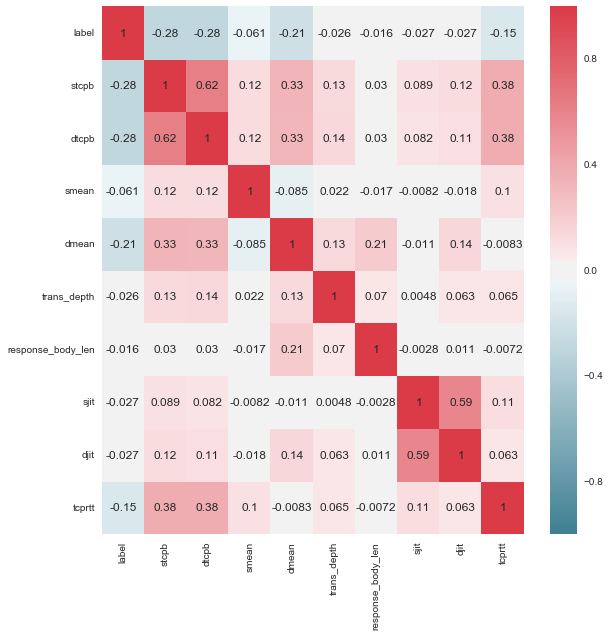

In [51]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_3.corr(), cmap=cmap, annot=True)

f.tight_layout()

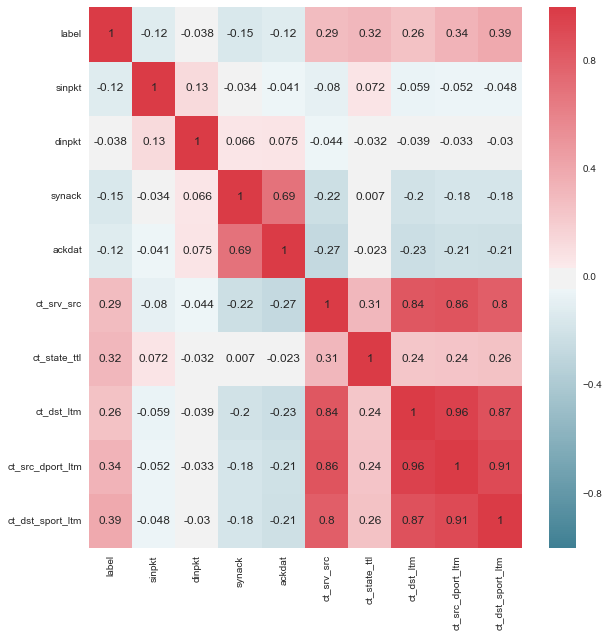

In [52]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_4.corr(), cmap=cmap, annot=True)

f.tight_layout()

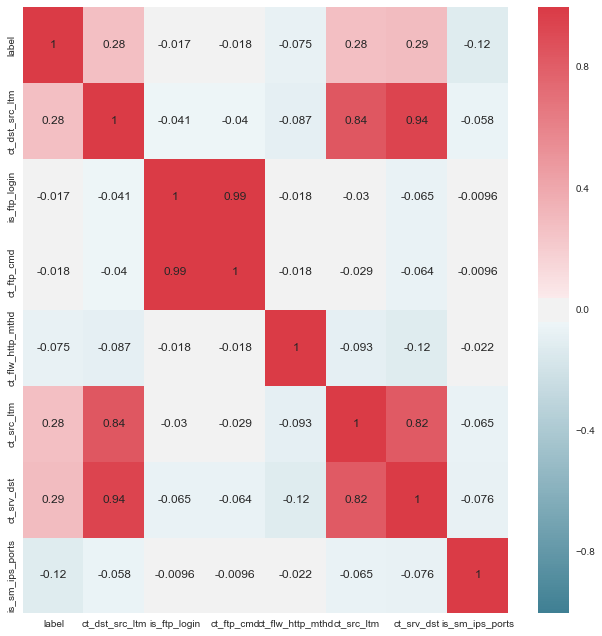

In [53]:
# NORMAL and ATTACK records

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_5.corr(), cmap=cmap, annot=True)

f.tight_layout()

**Scatter Plots** for interesting features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012EE6A90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000216549E8>]], dtype=object)

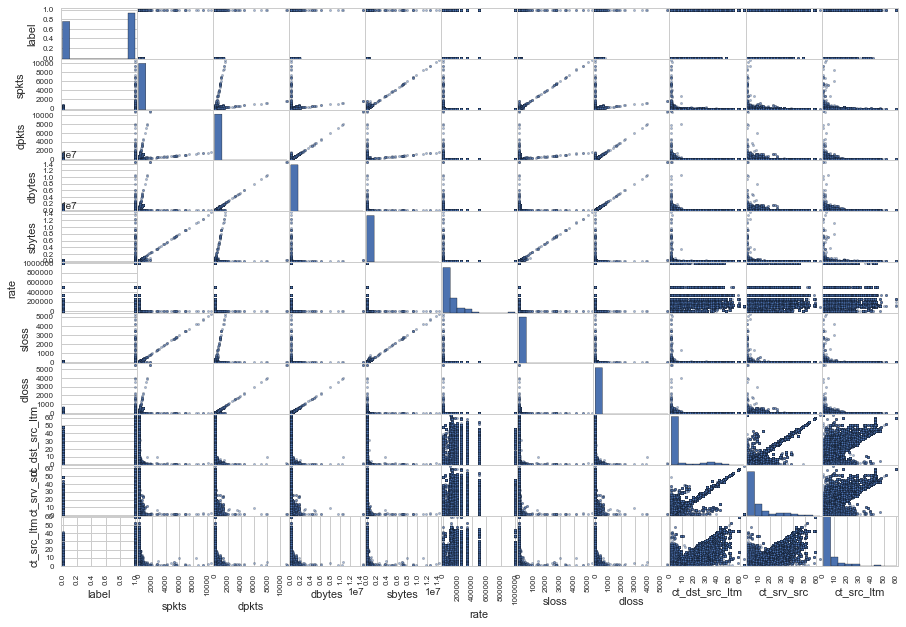

In [76]:
df_sub = df[['label', 'spkts', 'dpkts', 'dbytes', 'sbytes', 'rate', 'sloss', 'dloss', 'state', 'ct_dst_src_ltm', 'ct_srv_src', 'ct_src_ltm' ]]
df_corr = df_sub.corr(method='pearson')

header = df_sub.columns.values.tolist()
#print header
#len(header)
scatter_matrix(df_sub,figsize=(15, 10))

Looking at the scatter plot matrix, there appears to be varying degrees of positive linear correlation between the following features: dbytes - dloss; dpkts - dloss; sbytes sloss; spkts - sloss; ct_srv_src - ct_dst_src_ltm; dpkts - dbytes Other features are more difficult to find signifiant linear correlation due to binary nature of variable. The heat map below will help identify them visually based on color gradient which relates to strength.

In [77]:
df_corr

,label,spkts,dpkts,dbytes,sbytes,rate,sloss,dloss,ct_dst_src_ltm,ct_srv_src,ct_src_ltm
label,1.000000,-0.027728,-0.061513,-0.032629,0.020643,0.328662,0.006362,-0.044398,0.280008,0.290234,0.276512
spkts,-0.027728,1.000000,0.369554,0.198324,0.965750,-0.068251,0.973644,0.198683,-0.061854,-0.058719,-0.049368
dpkts,-0.061513,0.369554,1.000000,0.976419,0.175834,-0.083175,0.189060,0.981506,-0.075013,-0.062839,-0.057375
dbytes,-0.032629,0.198324,0.976419,1.000000,0.010036,-0.047981,0.014561,0.997109,-0.044049,-0.034333,-0.033303
sbytes,0.020643,0.965750,0.175834,0.010036,1.000000,-0.025103,0.995027,0.007091,-0.024066,-0.030206,-0.021540
rate,0.328662,-0.068251,-0.083175,-0.047981,-0.025103,1.000000,-0.040141,-0.062075,0.358897,0.367659,0.327558
sloss,0.006362,0.973644,0.189060,0.014561,0.995027,-0.040141,1.000000,0.014661,-0.035798,-0.040120,-0.031761
dloss,-0.044398,0.198683,0.981506,0.997109,0.007091,-0.062075,0.014661,1.000000,-0.056493,-0.045935,-0.043067
ct_dst_src_ltm,0.280008,-0.061854,-0.075013,-0.044049,-0.024066,0.358897,-0.035798,-0.056493,1.000000,0.933798,0.840012
ct_srv_src,0.290234,-0.058719,-0.062839,-0.034333,-0.030206,0.367659,-0.040120,-0.045935,0.933798,1.000000,0.822487


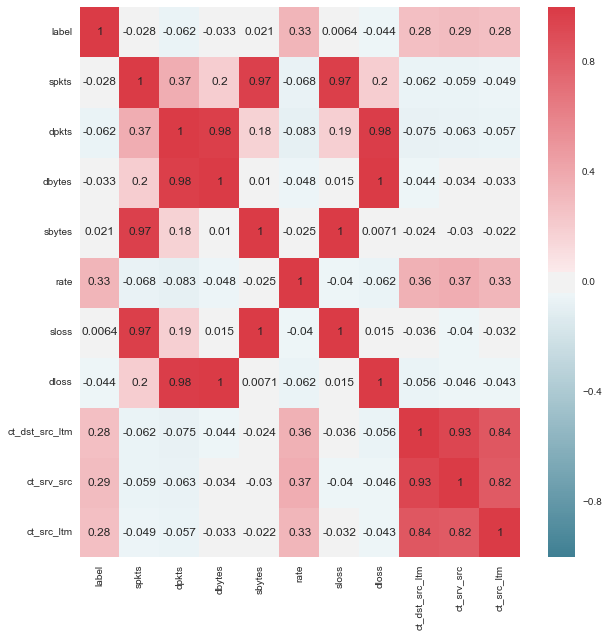

In [78]:
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df_corr, cmap=cmap, annot=True)
f.tight_layout()

### Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

Note: In the analysis in the "Explore relationships between attributes" section the cross tab of dpkts and label (normal/attack) fulfills some of this requirment as we believe there may be a relationship between *dpkts* (explanatory) and *label*(response)

**Parallel coordinate plot**: Attempting to find interesting relationships, we ran a few parallel coordinate plots on the features that were highly correlated with the *label* feature. In this first plot we see the relationship between *swin*, *dwin*, and *sttl* as it pertains to Attack(1) and Normal(0) traffic. 

We note that the attacks are always within one standard deviation of the mean, while Normal traffic extends beyond that. We think that we can use this information to help determine whether traffic is Normal if it is beyond one standard deviation. 

The second parallel coordinate plot shows how the Attack traffic uses more connections than the Normal traffic. These connections and their magnitude over one standard deviation can help us design a model to predict when an Attack may be occuring or about to occur.

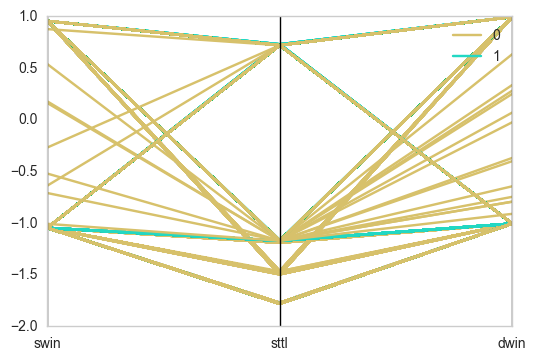

In [21]:
df_sub = df[['label','swin','sttl','dwin']]
df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
df_normalized.label = df_sub.label

parallel_coordinates(df_normalized,'label')

plt.figure()

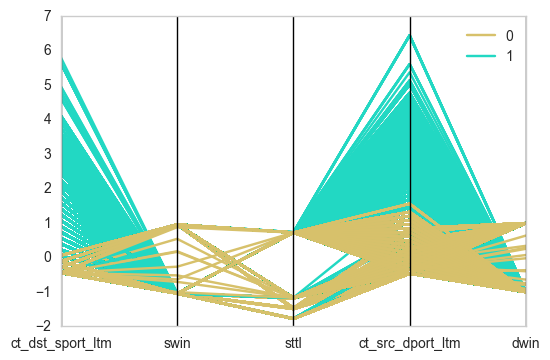

In [22]:
df_sub = df[['label','ct_dst_sport_ltm','swin','sttl','ct_src_dport_ltm','dwin']]

df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
df_normalized.label = df_sub.label

parallel_coordinates(df_normalized,'label')

plt.figure()

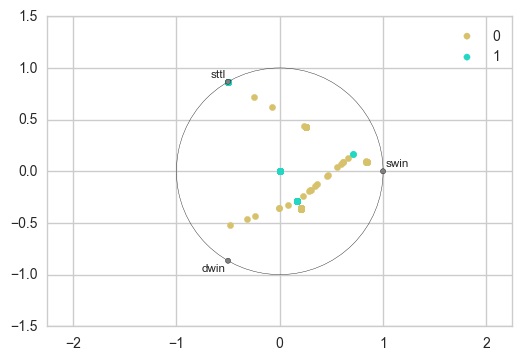

In [44]:
# RadViz is a way of visualizing multi-variate data. It is based on a simple spring tension
# minimization algorithm. Basically you set up a bunch of points in a plane. In our case they
# are equally spaced on a unit circle. Each point represents a single attribute. You then pretend
# that each sample in the data set is attached to each of these points by a spring, the stiffness of which is
# proportional to the numerical value of that attribute (they are normalized to unit interval).
# The point in the plane, where our sample settles to (where the forces acting on our sample are at an equilibrium) is where
# a dot representing our sample will be drawn. Depending on which class that sample belongs it will be colored differently.
df_sub = df[['label','swin','sttl','dwin']]
df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
df_normalized.label = df_sub.label

plt.figure()
radviz(df_sub, 'label')

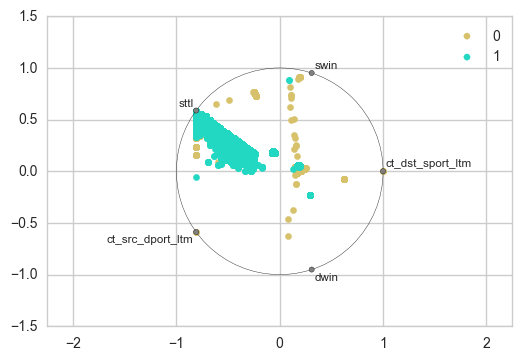

In [43]:
df_sub = df[['label','ct_dst_sport_ltm','swin','sttl','ct_src_dport_ltm','dwin']]

df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
df_normalized.label = df_sub.label

plt.figure()
radviz(df_sub, 'label')

We want to baseline our accuracy and F1 scores on the entire data set as a starting off point to compare the clustering's choices of features to add. We will first baseline on the entire data set and then get a random sampling pairs of features and baseline the metrics against that. 

In [4]:
# Go ahead and drop 'label' 
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()

# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to cluster!
dfcopy.info() # should have 190 featurers, ~40k entries
#http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.DataFrame.sample.html

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 190 entries, dur to state_RST
dtypes: float64(11), int64(28), uint8(151)
memory usage: 37.0 MB


In [24]:
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier



cv = StratifiedKFold(y,n_folds=10)
# n_estimators = The number of trees in the forest.
clf = RandomForestClassifier(n_estimators=150,random_state=1, max_features=5)

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100



Average accuracy =  79.3798613735 +- 11.3950481463


In [26]:
f1 = cross_val_score(clf,X,y=y,cv=cv,scoring="f1")

print "Average F1 = ", f1.mean()*100, "+-", f1.std()*100

Average F1 =  81.9879845807 +- 9.98498097654


The data set and comparisons to be done were too large for our machines when performing this step. To offset this problem, we decided to take a random sample of 0.5% of the data (412 observations) and run the accuracy and F1 statistics against this sampling, pulling out pairs of features at a time. We then sorted the pairs by best F1 and accuracy and ran the KMeans against that pair, adjust parameters on it.

In [44]:
# Go ahead and drop 'label' 
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
#http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.DataFrame.sample.html
dfCopyHalf = dfcopy.sample(frac=.005)
dfcopy = dfCopyHalf
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to cluster!
dfcopy.info() # should have 190 featurers, ~40k entries
#http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.DataFrame.sample.html

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 75732 to 36688
Columns: 190 entries, dur to state_RST
dtypes: float64(162), int64(28)
memory usage: 614.8 KB


In [5]:
pd.set_option('display.max_columns', 500)
dfcopy.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,4.120000e+02,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,4.120000e+02,4.120000e+02,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412,412,412.000000,412.000000,412.000000,412.000000,412,412,412,412,412,412,412.000000,412,412,412,412,412,412,412,412,412.000000,412,412,412,412,412,412,412,412,412,412,412.000000,412,412,412,412,412,412.000000,412.000000,412.000000,412.000000,412,412,412.000000,412,412,412,412,412.000000,412,412.000000,412,412,412,412.000000,412,412,412,412,412,412,412.000000,412.000000,412,412,412,412,412.000000,412,412,412,412,412,412,412,412,412.000000,412,412,412,412,412.000000,412.000000,412.000000,412,412,412,412,412,412,412,412.000000,412,412,412,412.000000,412,412,412,412.000000,412.000000,412,412,412.000000,412,412,412,412,412,412,412,412,412.000000,412,412,412,412.000000,412,412.000000,412.000000,412,412,412.000000,412.000000,412,412.000000,412,412,412,412,412,412.000000,412,412.000000,412,412,412.000000,412,412.000000,412.000000,412.000000,412.000000,412,412.000000,412,412.000000,412,412.000000,412,412,412,412.000000,412.000000,412.000000,412.000000,412
mean,1.200363,14.050971,12.111650,4045.847087,6380.211165,92791.877394,186.271845,88.279126,8.846707e+07,710021.587289,3.070388,3.963592,1010.636794,276.499301,8769.830136,601.734191,131.213592,1.107123e+09,1.026359e+09,123.786408,0.050587,0.026940,0.023646,152.944175,106.796117,0.104369,1452.286408,9.565534,1.432039,5.594660,4.859223,3.665049,7.487864,0,0,0.138350,6.274272,9.196602,0.012136,0,0,0,0,0,0,0.016990,0,0,0,0,0,0,0,0,0.002427,0,0,0,0,0,0,0,0,0,0,0.004854,0,0,0,0,0,0.002427,0.002427,0.002427,0.002427,0,0,0.002427,0,0,0,0,0.002427,0,0

Ref:09 Clustering and Discretization
Since we have a 190 features after 1 hot encoding, lets iterate through various pair wise classifications with the existing features to see what the best baseline classification we have
to perform futher clustering techniques upon.


In [6]:
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier



cv = StratifiedKFold(y,n_folds=10)
# n_estimators = The number of trees in the forest.
clf = RandomForestClassifier(n_estimators=150,random_state=1, max_features=5)

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100



Average accuracy =  90.3222996516 +- 2.74171603247


In [14]:
# Example of how to get label from dataframe column index.
print dfcopy.columns.get_level_values(0)[0]

dur


In [45]:
#print(X)
# http://stackoverflow.com/questions/18201690/get-unique-combinations-of-elements-from-a-python-list
from itertools import combinations
L = [1, 2, 3, 4]
#combo_list = [",".join(map(str, comb)) for comb in combinations(L, 2)]
#print combo_list
#print X.shape
# ref: http://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array
# e.g. columns 1, and 9. data[:, [1, 9]]
# Note: numpy indexes are zero-based ref: https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
X1 = X[:, [0,2]]
#print X1.shape

#  Note: if you interrupt the kernel, rerun the initialization cell above with X above.
from sklearn.cluster import KMeans 
import numpy as np
import pandas as pd

row, col = X.shape
print "col: ", col
L = range(col)
print L
combo_list = [comb for comb in combinations(L, 2)]
numCombos = len(combo_list)
print "combo_list size: ", numCombos
#combo_list = [",".join(map(str, comb)) for comb in combinations(L, 2)]
#print combo_list
counter = 0
resultList = []

import time
percentSample = .02 # 
import random
random.shuffle(combo_list)
sampleLength = (int)(percentSample * numCombos)
print "sampleLength: ", sampleLength
t0 = time.time()

# the combo_list is too long, lets just take a random sample and see what we find.


for trial in combo_list:
    counter+=1
    if counter > sampleLength: # Temporary until I get the formatting and data collection correct
        break
    #print trial
    f1, f2 = trial
    label1 = dfcopy.columns.get_level_values(0)[f1]
    label2 = dfcopy.columns.get_level_values(0)[f2]
    print("f1: ", f1, label1)
    print("f2: ", f2, label2)
    X1 = X[:, [f1, f2]]
    #X1 = df_imputed[['Pclass','Fare']]

    cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
    cls.fit(X1)
    newfeature = cls.labels_ # the labels from kmeans clustering

    X = np.column_stack((X,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    avgAcc = acc.mean()*100
    avgAccStd = acc.std()*100
    f1 = cross_val_score(clf, X, y=y, cv=cv, scoring='f1')# just testing to see if it is same as default
    avgF1 = f1.mean()*100
    avgF1Std = f1.std()*100
    
    print "Average accuracy (with kmeans for ", label1, "/", label2, ")= ", avgAcc, "+-", avgAccStd
    print "Average F1 (with kmeans for ", label1, "/", label2, ")= ", avgF1, "+-", avgF1Std
    resultList.append((avgAcc, avgAccStd, avgF1, avgF1Std, label1, label2)  )

t1 = time.time()
total = t1-t0
avgTime = total/counter
print "avg loop time: ", avgTime
print "total time: ", total
# http://stackoverflow.com/questions/10695139/sort-a-list-of-tuples-by-2nd-item-integer-value
from operator import itemgetter
resultListSorted = sorted(resultList,key=itemgetter(0), reverse=True)
print resultListSorted[0], resultListSorted[1]
print resultListSorted

col:  190
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]
combo_list size:  17955
sampleLength:  359
('f1: ', 33, u'is_ftp_login')
('f2: ', 183, u'state_ACC')
Average accuracy (with kmeans for  is_ftp_login 

Based on the results above the most accurate combination of 2 most accurate feature pairs (93.453542392566789, 2.858812883597337, 93.927190716538973, 2.6957426725603568, u'dpkts', u'sloss'), (92.983449477351925, 3.1315794075438981, 93.36949637178698, 3.2087479960698628, u'service_ftp-data', u'service_snmp') based on a random sample of random combination of features.
This discretization actually helps increase the accuracy on average,
from: Average accuracy =  90.3222996516 +- 2.74171603247 (pre discretization: baseline)
to: Average accuracy = 93.453542392566789 +- 2.858812883597337
but not really helping in the lowering of the deviation from the mean. What if we combine the different clusterings?


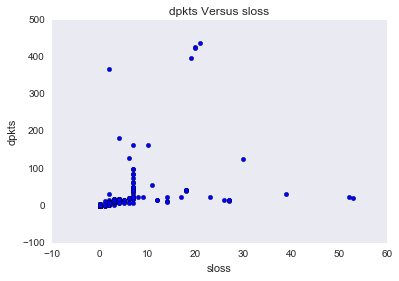

In [47]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("Set1", 8, .75)

%matplotlib inline
X1 = dfcopy[['dpkts','sloss']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('sloss'), plt.ylabel('dpkts')
plt.grid()
plt.title('dpkts Versus sloss')
plt.show()

In [25]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X1 = dfcopy[['smean','proto_il']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

# y = dfcopy['Survived']  # already setup a few cells ago.
# X = df_imputed[['Age','Sex','Parch','SibSp']]  # alerady setup a few cells ago.
X2 = np.column_stack((X,pd.get_dummies(newfeature)))  # Preserve X incase we want to use it again.

acc = cross_val_score(clf,X2,y=y,cv=cv)

print "Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100

Average accuracy (with kmeans for class/fare)=  90.3397212544 +- 6.80026253897


In [32]:
print len(newfeature)

412


Wow, I actually got a slight increase in accuracy (89 -> 90), but the error range almost doubled from 3.4 -> 6.8.  Also not sure about what value of n_clusters to use. Going to try again, with just n_clusters = 2.


In [26]:
X1 = dfcopy[['smean','proto_il']]

# n_clusters : The number of clusters to form as well as the number of centroids to generate.
# random_state : integer or numpy.RandomState, optional
cls = KMeans(n_clusters=2, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

# y = dfcopy['Survived']  # already setup a few cells ago.
# X = df_imputed[['Age','Sex','Parch','SibSp']]  # alerady setup a few cells ago.
X2 = np.column_stack((X,pd.get_dummies(newfeature)))  # Preserve X incase we want to use it again.

acc = cross_val_score(clf,X2,y=y,cv=cv)

print "Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100

Average accuracy (with kmeans for class/fare)=  90.7981997677 +- 5.71895176747


In [34]:
print newfeature

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1]


The average accuracy, again went up slighly, and error range decrease slighly as well. Interesting, but almost not significantly.

In [30]:
type(newfeature)
import sys
print sys.version

2.7.12 |Anaconda 2.3.0 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


## Modeling and Evaluation

#### Train and Adjust Parameters

## K-means
Reference:
(a) Introduction to Data Mining (Authors: Pang-Ning Tan, Michael Steinbach, Vipin Kumar)

Per ref (a) K-means clustering technique is a prototype-based, partitional clustering technique that attempts to find a users-specified number of clusters (K), which are represented by their centroids.
    In our particular dataset, we will be specifing K = 2 to see how well the clustering algorithm can discover the desired labels of malcious vs normal packets.  We will then run the algorith with K = 10 which would be the number of attack categories that were identified manually by hand from the dataset. Although, in a non simulated real world environment, this number may not really be known and hence this particular cluster algorithm may not be very practical to try and differentiate packets into category types as generally you would not know apriori the total number of attack categories over a batch of packets.  That said, making the assumption that there are normal vs abnormal packets may be a reasonable thing to suppose. 

('length of data = ', 20582)
2
Estimated number of clusters: 2
Homogeneity: 0.065
V-measure: 0.066
Adjusted Rand Index: 0.096
Adjusted Mutual Information: 0.065
Silhouette Coefficient: 0.653


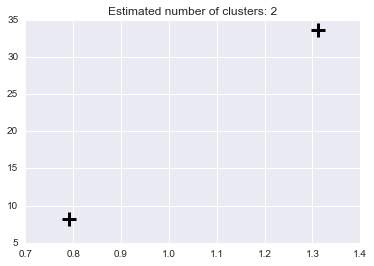

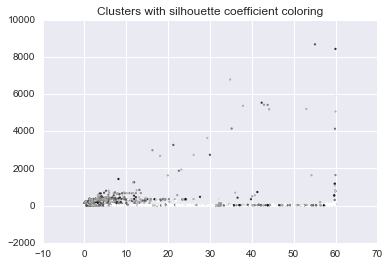

In [62]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

n_clusters = 2
data = X
model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
#model = DBSCAN(eps=0.15, min_samples=10).fit(data)
s_size = len(data)/2
print("length of data = ", s_size)
labels_pred = model.labels_
labels_true = y
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print( len(set(labels)))
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_pred))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_pred))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels_pred))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data, labels_pred, sample_size=s_size))

# Got memory error with silhouette/ reduced sample size in half
silhouette_per_sample = metrics.silhouette_samples(data,labels_pred)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):

    centroids.append( [np.mean(data[np.where(labels_pred==lab),0]), np.mean(data[np.where(labels_pred==lab),1])] )
centroids = np.array(centroids)

plt.figure()
#plt.scatter(data[:, 0], data[:, 1], c=labels,           
#                    cmap=plt.cm.spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
                cmap=plt.cm.gray, s=5, linewidths=0)
plt.title('Clusters with silhouette coefficient coloring')
plt.show()

We can see in the above two graphs that with two clusters using KMeans 

In [64]:
#curious if we run do feature reduction with PCA and run cluster algorith on reduced features if 
# the metrics like homogeneity improve
pca = PCA(n_components=3)
x_pca = pca.fit(X)

# Percentage of variance explained for each components
print('explained variance ratio (first 3 components): %s' % (100 * pca.explained_variance_ratio_) )
print(sum(pca.explained_variance_ratio_))

explained variance ratio (first 3 components): [ 80.59365547  18.59309631   0.81310102]
0.999998528038


In [82]:
from time import time

# ref: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
s_size = 42
sample_size = s_size
n_samples = s_size
n_digits = n_clusters  
n_features = len(dfcopy.columns)


print("n_digits(num categories): %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

   
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=1),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=1),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')



n_digits(num categories): 2, 	 n_samples 42, 	 n_features 42
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.43s    52908653520319819022336   1.000   1.000   1.000   1.000   1.000    0.602
   random   0.33s    52908655521244209217536   1.000   1.000   1.000   1.000   1.000    0.590
PCA-based   0.38s    52908653520319819022336   1.000   1.000   1.000   1.000   1.000    0.639
_______________________________________________________________________________


Ref:
(a)http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
    score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling

In [81]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=1)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the packets dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

MemoryError: 

We tried running the KMeans on data that was reduced using PCA, but were still unable to overcome the memory error that was caused from trying to crunch all the data.

## DBSCAN
DBSCAN is an algorithm based on the ‘density-based clustering’.  When given a set of points within a group, the algorithm is able to find sub groupings within the set.  Grouping of clusters is based on a density or the proximity of points, establishing ‘closest neighbors’ and identifying outliers located in ‘low-density areas’.  Some benefits of using DBSCAN are it does not require a number of specific clusters to start, it can find the most random of clusters, and it handles noise efficiently in data.  Some disadvantages of DBSCAN are, the quality of data output is dependent on distances and high dimensionality can be problematic, DBSCAN is not ideal with data sets with large differences in density, and if data is not understood well enough scalability can be difficult in optimizing thresholds. 

Reference: https://en.wikipedia.org/wiki/DBSCAN

We set up the DBSCAN the same way we set up the data originally, without reducing the features. We remove the *label* feature from the data frame, leaving us with 190 features. We then perform the DBSCAN.

In [19]:
# Go ahead and drop both 'label' 
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to predict!
dfcopy.info() # should have 190 entries
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 190 entries, dur to state_RST
dtypes: float64(11), int64(28), uint8(151)
memory usage: 37.0 MB


In [5]:
pd.set_option('display.max_columns', 500)
dfcopy.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
count,82328.000000,82328.000000,82328.000000,8.232800e+04,8.232800e+04,8.232800e+04,82328.000000,82328.00000,8.232800e+04,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,8.232800e+04,82328.000000,82328.000000,8.232800e+04,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.00000

1073
Estimated number of clusters: 1072


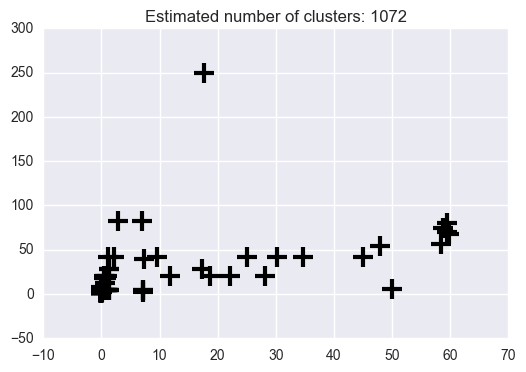

In [20]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

n_clusters = 4
data = X
#model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
#model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
model = DBSCAN(eps=0.15, min_samples=10).fit(data)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print( len(set(labels)))
print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(data, labels))

# Getting memory error with silhouette
#silhouette_per_sample = metrics.silhouette_samples(data,labels)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):

    centroids.append( [np.mean(data[np.where(labels==lab),0]), np.mean(data[np.where(labels==lab),1])] )
centroids = np.array(centroids)

plt.figure()
#plt.scatter(data[:, 0], data[:, 1], c=labels,           
#                    cmap=plt.cm.spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
#plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
#                cmap=plt.cm.gray, s=5, linewidths=0)
#plt.title('Clusters with silhouette coefficient coloring')
plt.show()

E:\anaconda\envs\py27\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


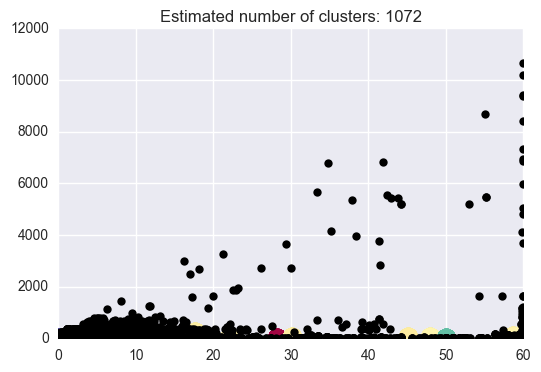

In [21]:
import matplotlib.pyplot as plt

dbsc = DBSCAN(eps = .5, min_samples = 15).fit(X)

labels = dbsc.labels_
core_samples_mask = np.zeros_like(labels, dtype = bool)
core_samples_mask[dbsc.core_sample_indices_] = True

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

We can see in the colored graph above of the 1072 estimated number of clusters that most of the data points lie along the x-axis. I was able to visually pick out maybe six clusters. The graph with the plus (+) symbols shows the clusters a little better, though it does not appear to match up with this graph. The scales are completely different, though, so the number of noise plots in the graph above may blocking them out. 

In [7]:
from sklearn.cluster import DBSCAN

clf = RandomForestClassifier(n_estimators=150,random_state=1, max_features=5)
cls = DBSCAN(eps = .5, min_samples = 15)
cls.fit(X)
newfeature = cls.labels_ # the labels from kmeans clustering

X2 = np.column_stack((X,pd.get_dummies(newfeature)))  # Preserve X incase we want to use it again.

f1 = cross_val_score(clf,X2,y=y,cv=3,scoring='f1')

print "Average F1 (with DBSCAN new features)= ", f1.mean()*100, "+-", f1.std()*100

Average F1 (with DBSCAN new features)=  94.0959660135 +- 1.95318676077


## MiniBatchKMeans

Reference:
http://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans

An optimized variant of the K-means clustering algorithm is the Mini Batch K-means algorithm which increases optimization by dividing the input data into mini-batches resulting in reduced computation time.  The tradeoff of converging to a local solution in each mini-batch is an overall reduction in the quality of the results, however, in practice the difference has been shown to be quite small.



In [4]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')
# Grab out the count of number of unique values in the attack_cat variable prior to removing it
# to use as a potential K value for Kmeans clustering algorithm

attack_cat = df.attack_cat.unique()
attack_cat_count = len(attack_cat)
print"Number of unique attack categories", attack_cat_count
# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining"
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print"[" + feature + "]" + "still found, check removal code. (Should not see this)"

df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] 

df_five.info()
df_five.describe()

Number of unique attack categories 10
duplicate record deleted successfully: 82328 observations remaining
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 6 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
label               82328 non-null int64
dtypes: int64(6)
memory usage: 4.4 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,1.000000


In [5]:
# One-hot encode our object features:

# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB


In [6]:
# Go ahead and drop 'label' 
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()

# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to cluster!
dfcopy.info() # should have 190 featurers, ~40k entries
#http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.DataFrame.sample.html

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 190 entries, dur to state_RST
dtypes: float64(11), int64(28), uint8(151)
memory usage: 37.0 MB


In [10]:
import time
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

n_clusters = 2

## KMeans
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1)
t0 = time.time()
k_means.fit(X)
t_kmeans = time.time() - t0


## MiniBatchKMeans
batch_size=100
mbk = MiniBatchKMeans(init='k-means++', n_clusters=2, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0


## DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=10)
t0 = time.time()
dbscan.fit(X)
t_dbscan = time.time() - t0


print "kmeans train time: %.2fs"%(t_kmeans)
print "mini batch train time: %.2fs"%(t_mini_batch)
print "dbscan train time: %.2fs"%(t_dbscan)

kmeans train time: 2.96s
mini batch train time: 1.55s
dbscan train time: 103.60s


In [12]:
clf = RandomForestClassifier(n_estimators=150,random_state=1, max_features=5)
cls = mbk
newfeature = cls.labels_ # the labels from kmeans clustering

X2 = np.column_stack((X,pd.get_dummies(newfeature)))  # Preserve X incase we want to use it again.

f1 = cross_val_score(clf,X2,y=y,cv=3,scoring='f1')

print "Average F1 (with MBK new features)= ", f1.mean()*100, "+-", f1.std()*100

Average F1 (with MBK new features)=  93.5056359393 +- 1.61457670585


From this comparison, we can see that mini batch is the most computationally inexpensive, but with the DBSCAN, we can see that it is the most effective at giving us a good F1 (94.0959660135 +- 1.95318676077). Looking back to our Lab 2 results, we see that this performs better than the PCA with the SelectKBest Random Forest model we created (91.5626617781). Unfortunately, we do not have at hand the standard deviation of the F1 score from the Random Forest PCA-SelectKBest model. 

#### Summarize the Ramifications

We thought that we would not be able to do better than our RandomForest with PCA and SelectKBest feature selection process, but the DBSCAN clustering features using the Random Forest model created an even better F1 score. KMeans gave us some good F1 scores, but not to the effect of the DBSCAN. The DBSCAN was computational taxing on our systems, but not as bad as the KMeans. The KMeans, we could not get through a PCA with three components without running out of memory. Due to this, the use of the KMeans seems unreliable, especially since we had to run the clustering for the KMeans on 0.5% of the data. 

The MiniBatch was used as a way to benchmark the clustering algorithms, but it turns out that it gives a very good F1 score as well (93.5056359393 +- 1.61457670585). It is not as good as the DBSCAN, though, but if we had more time, we would compare the results for statistical difference or not. It does perform a great deal faster, so if that is the highest priority, then it would be the one to choose.

We found that DBSCAN using the full data set (all 190 unlabeled columns and the 80k+ observations) gave us the best results, though, according to our benchmark, it was the slowest clustering algorithm. This was alright for our situation, as you will see in our deployment section, because we can run our algorithm as a batch on network traffic logs. If we needed near real time network intrusion analysis, going with the mini batch clustering algorithm would probably be our recommendation.

## Deployment

In this phase, we understand that our evaluation model has met business objectives and is receiving reliable score data. Making the model exceptionally useful for businesses & organizations seeking to protect assets from potential cyberattacks. The model’s performance and desirability rests on some identified variables being, the overall performance of the model to protect from attacks, the costs associated with attacks landed/ missed, and also “how well does the model grow?” These factors could help a customer’s decision making process to employing an algorithmic method. Ultimately our job would be to efficiently and effectively scale the methodology appropriately for each customer. Interested customers would have a clear understanding of the nature of their business and the amount of protection needed for their size of an organization. To properly deploy a model to the customer, they would need to be aware of the overhead related in performing certain algorithms, mostly being time and money. The updating process of such a model could be continuous, either by streaming in live time by the seconds or delivered in blocks of time, such as hourly/daily/weekly.

The customer would also have to make a decision on whether they wanted real time cyber attack protection or log scans. Real time coverage has overhead to consider, such as latency that the algorithm will cause, especially in high throughput networks. Log anaysis is much easier to implement, and if ran regularly enough, it may give the customers the reassurance they need that they have not been breached.